# Unconstrained Optimisation

This notebook contains code used to perform unconstrained optimisation using both random search and Bayesian optimisation.

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random
import pickle
import GPy
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.constraints import NonlinearInequalityConstraint
import matplotlib.style as style
import seaborn as sns

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import warnings
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

In [2]:
%run utilities.ipynb

In [3]:
# Load data
over18 = load_csv("../data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("../data/bbc-pandemic/contact_distributions_u18.csv")

# Scaling factor (universal)
nppl = 120

## Bayesian Optimisation

In this section, we find the optimal policy/ strategy using Bayesian optimisation. We consider variables that we can optimise including:

* go_to_school_prob
* wfh_prob
* isolate_individual_on_symptoms
* isolate_individual_on_positive
* isolate_household_on_symptoms
* isolate_household_on_positive
* isolate_contacts_on_symptoms
* isolate_contacts_on_positive
* test_contacts_on_positive
* do_symptom_testing
* do_manual_tracing
* do_app_tracing
* max_contacts
* quarantine_length

See **Utilities.ipynb** for description of each variable.


In [4]:
# List of variables to be optimised (see above)
variables_to_optimise = [
      'go_to_school_prob',
      'wfh_prob',
      'isolate_individual_on_symptoms',
      'isolate_individual_on_positive',
      'isolate_household_on_symptoms',
      'isolate_household_on_positive',
      'isolate_contacts_on_symptoms',
      'isolate_contacts_on_positive',
      'test_contacts_on_positive',
      'do_symptom_testing',
      'do_manual_tracing',
      'do_app_tracing',
      'max_contacts',
      'quarantine_length',
]

In [5]:
# Define all possible hyperparameter space
variable_domain = [0.0,1.0]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i+1 for i in range(20)]
boolean_domain = [True, False]
'''
go_to_school_prob
wfh_prob
isolate_individual_on_symptoms
isolate_individual_on_positive
isolate_household_on_symptoms
isolate_household_on_positive
isolate_contacts_on_symptoms
isolate_contacts_on_positive
test_contacts_on_positive
do_symptom_testing
do_manual_tracing
do_app_tracing
max_contacts
quarantine_length
'''
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('isolate_individual_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_individual_on_positive', boolean_domain),
           DiscreteParameter('isolate_household_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_household_on_positive', boolean_domain),
           DiscreteParameter('isolate_contacts_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_contacts_on_positive', boolean_domain),
           DiscreteParameter('test_contacts_on_positive', boolean_domain),
           DiscreteParameter('do_symptom_testing', boolean_domain),
           DiscreteParameter('do_manual_tracing', boolean_domain),
           DiscreteParameter('do_app_tracing', boolean_domain),
           DiscreteParameter('max_contacts', max_contacts_domain), 
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           ])

In [6]:
# Generate fixed list of cases and contacts for reproducibility
n_cases = 10000
list_cases, list_contacts = generate_cases(n_cases)

### Effective R

Perform unconstrained Bayesian optimisation on the effective R.

In [19]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         "Effective R")
    return y

In [20]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [31]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)


Optimization restart 1/1, f = 21.648721955799374



Optimization restart 1/1, f = 22.532092629060415



Optimization restart 1/1, f = 22.44610399173183



Optimization restart 1/1, f = 22.75464394711438



Optimization restart 1/1, f = 22.44477059598902



Optimization restart 1/1, f = 22.235939950071355



Optimization restart 1/1, f = 22.64675512725166



Optimization restart 1/1, f = 22.533596605917378



Optimization restart 1/1, f = 22.316709885917287



Optimization restart 1/1, f = 21.799821782994073



Optimization restart 1/1, f = 21.37969701947898



Optimization restart 1/1, f = 21.135001569903825



Optimization restart 1/1, f = 20.720037769506803



Optimization restart 1/1, f = 20.046479708432695



Optimization restart 1/1, f = 20.24635284689306



Optimization restart 1/1, f = 20.161008479687347



Optimization restart 1/1, f = 19.46701719270973



Optimization restart 1/1, f = 18.877983450553703



Optimization restart 1/1, f = 18.48612824336443



Optimization restart 1/1, f = 18.20702764634272



Optimization restart 1/1, f = 17.517542707594217



Optimization restart 1/1, f = 17.707751473079288



Optimization restart 1/1, f = 17.16664773423726



Optimization restart 1/1, f = 16.972662094176634



Optimization restart 1/1, f = 16.5811471939431



Optimization restart 1/1, f = 15.810261226991607



Optimization restart 1/1, f = 15.04344682454634



Optimization restart 1/1, f = 14.237643305274759



Optimization restart 1/1, f = 13.400466746227384



Optimization restart 1/1, f = 13.056064766055094



Optimization restart 1/1, f = 12.385442320442731



Optimization restart 1/1, f = 28.47657943556991



Optimization restart 1/1, f = 29.615028286769693



Optimization restart 1/1, f = 29.518885843926



Optimization restart 1/1, f = 29.695369763567108



Optimization restart 1/1, f = 30.835839438263783



Optimization restart 1/1, f = 29.71703857297448



Optimization restart 1/1, f = 28.595079062618506



Optimization restart 1/1, f = 27.269440765888138



Optimization restart 1/1, f = 27.39716383430945



Optimization restart 1/1, f = 26.568115263921893



Optimization restart 1/1, f = 18.623265385544016



Optimization restart 1/1, f = 10.678433484881868



Optimization restart 1/1, f = 2.7336072743146396



Optimization restart 1/1, f = 0.783064387757058



Optimization restart 1/1, f = -0.38164314217180717



Optimization restart 1/1, f = -0.6469320749430096



Optimization restart 1/1, f = -0.10877408631172969



Optimization restart 1/1, f = 7.548993480921368



Optimization restart 1/1, f = 6.040453457309468



Optimization restart 1/1, f = -2.0482076243362535



Optimization restart 1/1, f = -9.993034119188529



Optimization restart 1/1, f = -18.14058991209666



Optimization restart 1/1, f = -18.940484492385



Optimization restart 1/1, f = -18.747998176362852



Optimization restart 1/1, f = -26.92782430500466



Optimization restart 1/1, f = -27.86151260844087



Optimization restart 1/1, f = -27.34603704171491



Optimization restart 1/1, f = -28.69527073031778



Optimization restart 1/1, f = -36.640092186505704



Optimization restart 1/1, f = -44.58491031808788



Optimization restart 1/1, f = -52.785149124025565



Optimization restart 1/1, f = 12.829748684229436



Optimization restart 1/1, f = 16.401827421859057



Optimization restart 1/1, f = 15.594812790518246



Optimization restart 1/1, f = 15.030816580404585



Optimization restart 1/1, f = 1.6990565391415817



Optimization restart 1/1, f = -6.448503871510692



Optimization restart 1/1, f = -14.628333519364993



Optimization restart 1/1, f = -22.82857422523856



Optimization restart 1/1, f = -22.087510264231504



Optimization restart 1/1, f = -30.301836357998692



Optimization restart 1/1, f = -38.52647211174209



Optimization restart 1/1, f = -46.75898200391683



Optimization restart 1/1, f = -46.847609116823634



Optimization restart 1/1, f = -55.08633026350455



Optimization restart 1/1, f = -63.330076574492075



Optimization restart 1/1, f = -63.44695327891216



Optimization restart 1/1, f = -64.61816219728553



Optimization restart 1/1, f = -72.86605794954221



Optimization restart 1/1, f = -81.11743803666903



Optimization restart 1/1, f = -89.3717854917224



Optimization restart 1/1, f = -97.62869049724246



Optimization restart 1/1, f = -105.88782267804558



Optimization restart 1/1, f = -114.14891180859846



Optimization restart 1/1, f = -122.4117340432139



Optimization restart 1/1, f = -130.6761018741768



Optimization restart 1/1, f = -131.54906432255854



Optimization restart 1/1, f = -139.8148191171859



Optimization restart 1/1, f = -148.08182547674184



Optimization restart 1/1, f = -156.34996691060954



Optimization restart 1/1, f = -164.61914247104795



Optimization restart 1/1, f = -172.88926410559623


In [35]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"Minimum effective R: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum effective R: 0.3832926697318112
Strategy:


{'go_to_school_prob': 0.0,
 'wfh_prob': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 1.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,0.4
# Manual Traces (k per day),142.6
# App Traces (k per day),20.0
# Tests Needed (k per day),101.7


In [36]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"Minimum effective R: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
Minimum effective R: 0.3832926697318112
Strategy:


{'go_to_school_prob': 0.0,
 'wfh_prob': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 1.0,
 'do_manual_tracing': 1.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 10.0}

,Simulation results:
Base R,3.9
Effective R,0.4
# Manual Traces (k per day),142.6
# App Traces (k per day),20.0
# Tests Needed (k per day),101.7


In [37]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"Minimum effective R: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
Minimum effective R: 0.3832926697318112
Strategy:


{'go_to_school_prob': 0.0,
 'wfh_prob': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 1.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,0.4
# Manual Traces (k per day),142.6
# App Traces (k per day),20.0
# Tests Needed (k per day),101.7


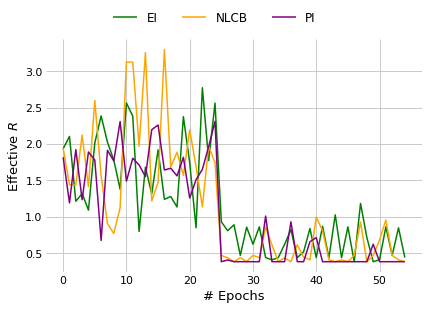

In [58]:
# Plot function output across epochs
y1 = [ele[0] for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0] for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0] for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel("Effective $R$", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [83]:
## Parallel coordinate plot 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei['Effective R'] = ei_bayesopt_loop.model.model.Y

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb['Effective R'] = nlcb_bayesopt_loop.model.model.Y

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi['Effective R'] = pi_bayesopt_loop.model.model.Y

# Store the result
# df_ei.to_csv("../results/ei-bo-unconstrained.csv")
# df_nlcb.to_csv("../results/nlcb-bo-unconstrained.csv")
# df_pi.to_csv("../results/pi-bo-unconstrained.csv")

In [108]:
# # Plot hyperparam result
# df_ei["do_symptom_testing"] = df_ei["do_symptom_testing"].map({True: 0.9, False: 0.1})
# df_ei["do_manual_tracing"] = df_ei["do_manual_tracing"].map({True: 0.9, False: 0.1})
# df_ei["do_app_tracing"] = df_ei["do_app_tracing"].map({True: 0.9, False: 0.1})

# fig = go.Figure(data=
#     go.Parcoords(
#         line = dict(color = df_ei["Effective R"],
#                    colorscale = "Electric",
#                    showscale = True,
#                    cmin = 0,
#                    cmax = 4),
#         dimensions = list([
#             dict(range = [0,1],
#                  label = "GTS probability", values = df_ei["go_to_school_prob"]),
#             dict(range = [0,1],
#                  label = "WFH probability", values = df_ei["wfh_prob"]),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'Symptom testing', values = df_ei['do_symptom_testing']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'Manual tracing', values = df_ei['do_manual_tracing']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'App tracing', values = df_ei['do_app_tracing']),
#             dict(range = [1,20],
#                  label = "Max contacts", values = df_ei["max_contacts"]),
#             dict(range = [0,14],
#                  label = "Quarantine length", values = df_ei["quarantine_length"]),
#             dict(range = [0, 4],
#                  label = 'Effective R', values = df_ei['Effective R'])
        
#         ])
#     )
#                )

# fig.update_layout(
#     plot_bgcolor = 'white',
#     paper_bgcolor = 'white',
#     font_size=15
# )
# fig.show()

<div>
<img src="../results/unconstrained_bo_parallel_plot.png" style="height:35em"/>
</div>

In [109]:
# # Plot hyperparam result
# df_ei["isolate_individual_on_symptoms"] = df_ei["isolate_individual_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_individual_on_positive"] = df_ei["isolate_individual_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["isolate_household_on_symptoms"] = df_ei["isolate_household_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_household_on_positive"] = df_ei["isolate_household_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["isolate_contacts_on_symptoms"] = df_ei["isolate_contacts_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_contacts_on_positive"] = df_ei["isolate_contacts_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["test_contacts_on_positive"] = df_ei["test_contacts_on_positive"].map({True: 0.9, False: 0.1})

# fig = go.Figure(data=
#     go.Parcoords(
#         line = dict(color = df_ei["Effective R"],
#                    colorscale = "Electric",
#                    showscale = True,
#                    cmin = 0,
#                    cmax = 4),
#         dimensions = list([
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'IIS', values = df_ei['isolate_individual_on_symptoms']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'IIP', values = df_ei['isolate_individual_on_positive']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'IHS', values = df_ei['isolate_household_on_symptoms']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'IHP', values = df_ei['isolate_household_on_positive']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'ICS', values = df_ei['isolate_contacts_on_symptoms']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'ICP', values = df_ei['isolate_contacts_on_positive']),
#             dict(range = [0,1],
#                  tickvals = [0.1,0.9],
#                  ticktext=["False", "True"],
#                  label = 'TCP', values = df_ei['test_contacts_on_positive']),
#             dict(range = [0, 4],
#                  label = 'Effective R', values = df_ei['Effective R'])
        
#         ])
#     )
#                )

# fig.update_layout(
#     plot_bgcolor = 'white',
#     paper_bgcolor = 'white',
#     font_size=15
# )
# fig.show()

<div>
<img src="../results/unconstrained_bo_parallel_plot2.png" style="height:35em"/>
</div>

In [4]:
## Sort policies result
df_ei = pd.read_csv("../results/ei-bo-unconstrained.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-unconstrained.csv")
df_pi = pd.read_csv("../results/pi-bo-unconstrained.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values("Effective R").head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,Effective R
46,0.000000,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,0.383293
49,0.000000,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,14.0,0.383293
33,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,0.408596
50,0.000000,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,10.0,0.408596
42,0.000000,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,14.0,0.435704
44,0.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,0.439169
34,0.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,0.439169
37,0.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,0.439169
32,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,0.439504
40,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,0.439504


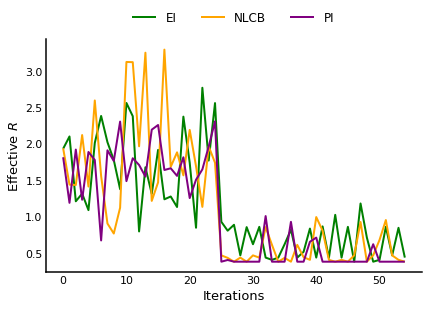

In [11]:
# Plot function output across epochs
y1 = df_ei["Effective R"]
y2 = df_nlcb["Effective R"]
y3 = df_pi["Effective R"]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=2)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=2)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.2, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("Iterations", fontsize=13)
ax.set_ylabel("Effective $R$", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")
ax.grid(False)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

**Note**: from the above, we can rank policies found by the Bayesian optimisation procedure. 

### # of Tests

In [21]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         "# Tests Needed")
    return y

In [23]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [24]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

Optimization restart 1/1, f = 12.109176946813523



Optimization restart 1/1, f = 12.044001734956966



Optimization restart 1/1, f = 11.949714074454535



Optimization restart 1/1, f = 11.835787311376757



Optimization restart 1/1, f = 11.711699507831934



Optimization restart 1/1, f = 11.560668816602778



Optimization restart 1/1, f = 14.270570303684602



Optimization restart 1/1, f = 14.168578902423405



Optimization restart 1/1, f = 14.046942020327169



Optimization restart 1/1, f = 13.914275505206227



Optimization restart 1/1, f = 13.764411823772715



Optimization restart 1/1, f = 13.596363291176353



Optimization restart 1/1, f = 13.413733361809527



Optimization restart 1/1, f = 15.977872231947721



Optimization restart 1/1, f = 29.42366644738385



Optimization restart 1/1, f = 29.63387247400388



Optimization restart 1/1, f = 29.831060552230223



Optimization restart 1/1, f = 31.451760482466387



Optimization restart 1/1, f = 32.968123619690175



Optimization restart 1/1, f = 33.187345627420406



Optimization restart 1/1, f = 33.394795628859015



Optimization restart 1/1, f = 34.85484018816907



Optimization restart 1/1, f = 36.23833769819214



Optimization restart 1/1, f = 36.464791232722035



Optimization restart 1/1, f = 36.680382954081125



Optimization restart 1/1, f = 38.02544990211095



Optimization restart 1/1, f = 41.601270671613094



Optimization restart 1/1, f = 41.875793248994334



Optimization restart 1/1, f = 42.14049667428348



Optimization restart 1/1, f = 42.395193679983805



Optimization restart 1/1, f = 48.47464189027717
Optimization restart 1/1, f = 12.10917694680357



Optimization restart 1/1, f = 12.035291423025939



Optimization restart 1/1, f = 11.940975632342708



Optimization restart 1/1, f = 14.471741842056987



Optimization restart 1/1, f = 17.84677118799887



Optimization restart 1/1, f = 17.909625935121436



Optimization restart 1/1, f = 17.95910026207816



Optimization restart 1/1, f = 20.001333289242115



Optimization restart 1/1, f = 20.067334580550167



Optimization restart 1/1, f = 20.110036161981835



Optimization restart 1/1, f = 20.14615236646916



Optimization restart 1/1, f = 22.969736463842498



Optimization restart 1/1, f = 23.06308519671376



Optimization restart 1/1, f = 23.300774409787365



Optimization restart 1/1, f = 23.37800847970336



Optimization restart 1/1, f = 23.437978797096235



Optimization restart 1/1, f = 23.48493859731423



Optimization restart 1/1, f = 23.523145422545184



Optimization restart 1/1, f = 23.54505755062519



Optimization restart 1/1, f = 23.55882937695942



Optimization restart 1/1, f = 23.560813054362992



Optimization restart 1/1, f = 25.69976308783737



Optimization restart 1/1, f = 25.719608041646563



Optimization restart 1/1, f = 25.72420081141176



Optimization restart 1/1, f = 25.717995221954105



Optimization restart 1/1, f = 25.701224301979437



Optimization restart 1/1, f = 25.675153569420832



Optimization restart 1/1, f = 25.637891980398514



Optimization restart 1/1, f = 25.591743085665733



Optimization restart 1/1, f = 25.534793697586014



Optimization restart 1/1, f = 25.468279340721743
Optimization restart 1/1, f = 12.10917694680357



Optimization restart 1/1, f = 28.834688587804383



Optimization restart 1/1, f = 30.302188118213685



Optimization restart 1/1, f = 30.890202707324942



Optimization restart 1/1, f = 31.45560284021755



Optimization restart 1/1, f = 32.00294225760824



Optimization restart 1/1, f = 33.40190815322827



Optimization restart 1/1, f = 33.93637475951117



Optimization restart 1/1, f = 34.45652054223033



Optimization restart 1/1, f = 35.79946896962427



Optimization restart 1/1, f = 36.30857049265083



Optimization restart 1/1, f = 36.803539973326565



Optimization restart 1/1, f = 37.28170223875465



Optimization restart 1/1, f = 37.7457591347472



Optimization restart 1/1, f = 39.05414251204879



Optimization restart 1/1, f = 39.51199712570711



Optimization restart 1/1, f = 39.95619550076955



Optimization restart 1/1, f = 40.38723691073327



Optimization restart 1/1, f = 40.812614359319156



Optimization restart 1/1, f = 41.22143489722524



Optimization restart 1/1, f = 41.66344200327087



Optimization restart 1/1, f = 42.048804765161115



Optimization restart 1/1, f = 42.422886640492564



Optimization restart 1/1, f = 42.78724725594573



Optimization restart 1/1, f = 44.12610122531322



Optimization restart 1/1, f = 44.48661738129125



Optimization restart 1/1, f = 44.838152231991266



Optimization restart 1/1, f = 45.17904403282574



Optimization restart 1/1, f = 45.509433683642



Optimization restart 1/1, f = 45.830095458618445



Optimization restart 1/1, f = 47.15982053919639


In [27]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"# Tests Needed: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
# Tests Needed: 0.0
Strategy:


{'go_to_school_prob': 0.11131191280147357,
 'wfh_prob': 0.6462454732497919,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 8.0,
 'quarantine_length': 9.0}

,Simulation results:
Base R,3.9
Effective R,1.3
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


In [28]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"# Tests Needed: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
# Tests Needed: 0.0
Strategy:


{'go_to_school_prob': 0.11131191280147357,
 'wfh_prob': 0.6462454732497919,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 8.0,
 'quarantine_length': 9.0}

,Simulation results:
Base R,3.9
Effective R,1.3
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


In [29]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"# Tests Needed: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
# Tests Needed: 0.0
Strategy:


{'go_to_school_prob': 0.11131191280147357,
 'wfh_prob': 0.6462454732497919,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 8.0,
 'quarantine_length': 9.0}

,Simulation results:
Base R,3.9
Effective R,1.3
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


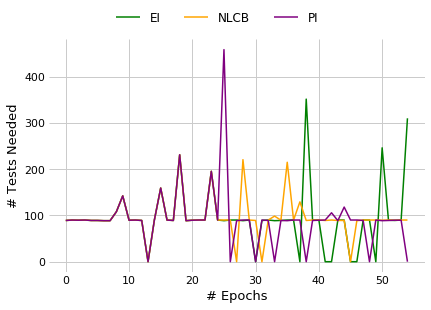

In [34]:
# Plot function output across epochs
y1 = [ele[0]*nppl for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0]*nppl for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0]*nppl for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel("# Tests Needed", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [38]:
## Parallel coordinate plot 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei['# Tests Needed'] = ei_bayesopt_loop.model.model.Y * nppl

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb['# Tests Needed'] = nlcb_bayesopt_loop.model.model.Y * nppl

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi['# Tests Needed'] = pi_bayesopt_loop.model.model.Y * nppl

# Store the result
df_ei.to_csv("../results/ei-bo-unconstrained-tests.csv")
df_nlcb.to_csv("../results/nlcb-bo-unconstrained-tests.csv")
df_pi.to_csv("../results/pi-bo-unconstrained-tests.csv")

In [39]:
## Sort policies result
df_ei = pd.read_csv("../results/ei-bo-unconstrained-tests.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-unconstrained-tests.csv")
df_pi = pd.read_csv("../results/pi-bo-unconstrained-tests.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values("# Tests Needed").head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# Tests Needed
41,0.288934,0.803177,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000
37,0.469537,0.066261,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000
30,0.507146,0.555940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000
46,0.063233,0.989490,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000
49,0.226116,0.303130,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000
42,0.065144,0.396137,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000
45,0.769052,0.784403,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000
13,0.111312,0.646245,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,9.0,0.000
33,0.358771,0.807165,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,88.728
19,0.359032,0.873961,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,20.0,0.0,88.728


### # of App Traces

In [40]:
KEY = "# App Traces"
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [41]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [42]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

Optimization restart 1/1, f = 31.43639844964008



Optimization restart 1/1, f = 32.18457199197761



Optimization restart 1/1, f = 32.8916271000445



Optimization restart 1/1, f = 33.56275523932863



Optimization restart 1/1, f = 34.19983880849379



Optimization restart 1/1, f = 34.806151596350105



Optimization restart 1/1, f = 35.38184097990121



Optimization restart 1/1, f = 35.930860312370626



Optimization restart 1/1, f = 36.45717560827859



Optimization restart 1/1, f = 36.9619992118878



Optimization restart 1/1, f = 37.438090066956654



Optimization restart 1/1, f = 37.91322708511901



Optimization restart 1/1, f = 38.35026311464303



Optimization restart 1/1, f = 38.764463869804295



Optimization restart 1/1, f = 39.231987142712356



Optimization restart 1/1, f = 39.612397020897305



Optimization restart 1/1, f = 39.974984577573366



Optimization restart 1/1, f = 40.308531533290136



Optimization restart 1/1, f = 40.62225296916007



Optimization restart 1/1, f = 40.92176421484277



Optimization restart 1/1, f = 41.292584816055026



Optimization restart 1/1, f = 41.561417092744634



Optimization restart 1/1, f = 29.980115751255347



Optimization restart 1/1, f = 36.469723138265465



Optimization restart 1/1, f = 39.88311497455379



Optimization restart 1/1, f = 39.642703341711794



Optimization restart 1/1, f = 40.57786861649947



Optimization restart 1/1, f = 41.125706707606895



Optimization restart 1/1, f = 41.74667646176159



Optimization restart 1/1, f = 42.1531801371683



Optimization restart 1/1, f = 42.71889942062569
Optimization restart 1/1, f = 31.436398449640073



Optimization restart 1/1, f = 32.184464778757985



Optimization restart 1/1, f = 32.891532285544656



Optimization restart 1/1, f = 33.56238783730814



Optimization restart 1/1, f = 34.201099150667716



Optimization restart 1/1, f = 34.81188548567193



Optimization restart 1/1, f = 35.39149738514102



Optimization restart 1/1, f = 35.94414308232786



Optimization restart 1/1, f = 36.47303203657961



Optimization restart 1/1, f = 36.971873810102196



Optimization restart 1/1, f = 37.46493694765351



Optimization restart 1/1, f = 37.93757532803637



Optimization restart 1/1, f = 38.44025690126377



Optimization restart 1/1, f = 38.86661896366878



Optimization restart 1/1, f = 39.27084717831998



Optimization restart 1/1, f = 39.65915936251644



Optimization restart 1/1, f = 40.03121423147236



Optimization restart 1/1, f = 40.38098105451347



Optimization restart 1/1, f = 40.709444004924876



Optimization restart 1/1, f = 41.01641900151069



Optimization restart 1/1, f = 41.307599684564366



Optimization restart 1/1, f = 41.64435519496372



Optimization restart 1/1, f = 41.90222782415124



Optimization restart 1/1, f = 42.15119661254335



Optimization restart 1/1, f = 32.4502164867435



Optimization restart 1/1, f = 37.62518209822214



Optimization restart 1/1, f = 41.91611529781565



Optimization restart 1/1, f = 42.8667677905981



Optimization restart 1/1, f = 43.5088629374596



Optimization restart 1/1, f = 44.09644094755616



Optimization restart 1/1, f = 44.677092544205294
Optimization restart 1/1, f = 31.436398449640073



Optimization restart 1/1, f = 32.1850929051061



Optimization restart 1/1, f = 32.89110513491811



Optimization restart 1/1, f = 33.560519723165456



Optimization restart 1/1, f = 34.19680766199389



Optimization restart 1/1, f = 34.79567711102085



Optimization restart 1/1, f = 35.3626958703986



Optimization restart 1/1, f = 35.902663093333686



Optimization restart 1/1, f = 36.413375424446514



Optimization restart 1/1, f = 36.91489311413653



Optimization restart 1/1, f = 37.380338140682184



Optimization restart 1/1, f = 37.82325139679871



Optimization restart 1/1, f = 38.23290451775841



Optimization restart 1/1, f = 38.62037398242654



Optimization restart 1/1, f = 38.98493094753566



Optimization restart 1/1, f = 39.33147302256722



Optimization restart 1/1, f = 39.65996667099484



Optimization restart 1/1, f = 39.96330133624208



Optimization restart 1/1, f = 6.546414171863546



Optimization restart 1/1, f = 11.95179968637034



Optimization restart 1/1, f = 17.529673893802226



Optimization restart 1/1, f = 19.450417124740913



Optimization restart 1/1, f = 13.583280008277722



Optimization restart 1/1, f = 5.772720713470395



Optimization restart 1/1, f = -2.2262383069179847



Optimization restart 1/1, f = -10.307011329692088



Optimization restart 1/1, f = -18.4343897895994



Optimization restart 1/1, f = -23.850657324303555



Optimization restart 1/1, f = -31.015517202383155



Optimization restart 1/1, f = -38.78333837836172



Optimization restart 1/1, f = -37.75136817232877


In [43]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum # App Traces: 0.0
Strategy:


{'go_to_school_prob': 0.414297108314732,
 'wfh_prob': 0.44732781425633694,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 14.0,
 'quarantine_length': 10.0}

,Simulation results:
Base R,3.9
Effective R,1.6
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),89.2


In [44]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
Minimum # App Traces: 0.0
Strategy:


{'go_to_school_prob': 0.414297108314732,
 'wfh_prob': 0.44732781425633694,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 14.0,
 'quarantine_length': 10.0}

,Simulation results:
Base R,3.9
Effective R,1.6
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),89.2


In [45]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
Minimum # App Traces: 0.0
Strategy:


{'go_to_school_prob': 0.414297108314732,
 'wfh_prob': 0.44732781425633694,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 14.0,
 'quarantine_length': 10.0}

,Simulation results:
Base R,3.9
Effective R,1.6
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),89.2


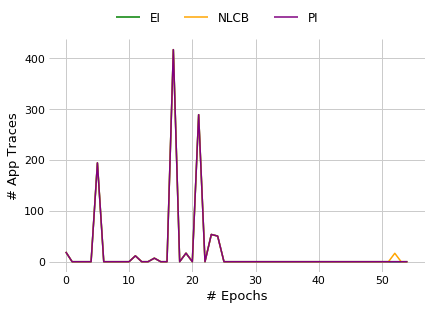

In [46]:
# Plot function output across epochs
y1 = [ele[0]*nppl for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0]*nppl for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0]*nppl for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(KEY, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [47]:
## df aggregate 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei[KEY] = ei_bayesopt_loop.model.model.Y * nppl

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb[KEY] = nlcb_bayesopt_loop.model.model.Y * nppl

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi[KEY] = pi_bayesopt_loop.model.model.Y * nppl

# Store the result
df_ei.to_csv("../results/ei-bo-unconstrained-app.csv")
df_nlcb.to_csv("../results/nlcb-bo-unconstrained-app.csv")
df_pi.to_csv("../results/pi-bo-unconstrained-app.csv")

In [48]:
## Sort policies result
df_ei = pd.read_csv("../results/ei-bo-unconstrained-app.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-unconstrained-app.csv")
df_pi = pd.read_csv("../results/pi-bo-unconstrained-app.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# App Traces
27,0.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000
29,-6.938894e-18,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000
30,1.000000e+00,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000
31,0.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,5.0,0.000
32,0.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,6.0,0.000
33,1.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,7.0,0.000
34,1.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,0.0,0.000
35,1.000000e+00,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,9.0,0.000
36,1.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.000
37,0.000000e+00,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,0.0,0.000


### # of Manual Traces

In [49]:
KEY = "# Manual Traces"

In [50]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [51]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [52]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

Optimization restart 1/1, f = 89.14187797297221



Optimization restart 1/1, f = 92.28954117409323



Optimization restart 1/1, f = 95.4166787148865



Optimization restart 1/1, f = 98.52416929757763



Optimization restart 1/1, f = 101.61281394987971



Optimization restart 1/1, f = 104.68334499743463



Optimization restart 1/1, f = 107.73643730190605



Optimization restart 1/1, f = 110.72036243400527



Optimization restart 1/1, f = 113.65476640906839



Optimization restart 1/1, f = 116.99161904551406



Optimization restart 1/1, f = 120.00979156391222



Optimization restart 1/1, f = 123.01292423847414



Optimization restart 1/1, f = 126.00148552088503



Optimization restart 1/1, f = 128.9759145035499



Optimization restart 1/1, f = 131.93662224177208



Optimization restart 1/1, f = 134.8839949922932



Optimization restart 1/1, f = 137.81839717030152



Optimization restart 1/1, f = 140.74017120797734



Optimization restart 1/1, f = 143.64964596224488



Optimization restart 1/1, f = 146.47507557892797



Optimization restart 1/1, f = 149.36216705690825



Optimization restart 1/1, f = 152.17033326321203



Optimization restart 1/1, f = 155.0358203220687



Optimization restart 1/1, f = 157.89035714103886



Optimization restart 1/1, f = 160.73418689518064



Optimization restart 1/1, f = 163.5675422370077



Optimization restart 1/1, f = 166.39064511801055



Optimization restart 1/1, f = 169.20370753830355



Optimization restart 1/1, f = 172.0069331817601



Optimization restart 1/1, f = 174.8005171728482



Optimization restart 1/1, f = 177.58464733159497
Optimization restart 1/1, f = 89.1418779729722



Optimization restart 1/1, f = 92.23579095987894



Optimization restart 1/1, f = 95.3638798884078



Optimization restart 1/1, f = 98.47225844589406



Optimization restart 1/1, f = 101.5617365496047



Optimization restart 1/1, f = 104.63305430991747



Optimization restart 1/1, f = 107.68689105205107



Optimization restart 1/1, f = 110.72387424563487



Optimization restart 1/1, f = 113.74458700593482



Optimization restart 1/1, f = 116.74956541463501



Optimization restart 1/1, f = 119.73931368240675



Optimization restart 1/1, f = 122.71430348950003



Optimization restart 1/1, f = 125.67497445687161



Optimization restart 1/1, f = 129.0739421041495



Optimization restart 1/1, f = 132.03192181007893



Optimization restart 1/1, f = 134.97662484241332



Optimization restart 1/1, f = 137.90841092728914



Optimization restart 1/1, f = 140.82761829038446



Optimization restart 1/1, f = 143.73456791206593



Optimization restart 1/1, f = 146.62956428424303



Optimization restart 1/1, f = 149.5128968209156



Optimization restart 1/1, f = 152.38483971574323



Optimization restart 1/1, f = 155.24565362178828



Optimization restart 1/1, f = 158.09559209633971



Optimization restart 1/1, f = 160.93488662792365



Optimization restart 1/1, f = 163.76376823586003



Optimization restart 1/1, f = 166.58245412649086



Optimization restart 1/1, f = 174.81279315898377



Optimization restart 1/1, f = 177.7262675256541



Optimization restart 1/1, f = 180.6300841091658



Optimization restart 1/1, f = 183.52443236145686
Optimization restart 1/1, f = 89.1418779729722



Optimization restart 1/1, f = 92.28954137028538



Optimization restart 1/1, f = 95.41667882397346



Optimization restart 1/1, f = 98.52416940581708



Optimization restart 1/1, f = 101.61281393435753



Optimization restart 1/1, f = 104.68334504175169



Optimization restart 1/1, f = 107.73643696120818



Optimization restart 1/1, f = 110.7727151544733



Optimization restart 1/1, f = 113.79275135770257



Optimization restart 1/1, f = 116.79708382202885



Optimization restart 1/1, f = 119.7862137145618



Optimization restart 1/1, f = 122.76060750980524



Optimization restart 1/1, f = 125.72070469257491



Optimization restart 1/1, f = 128.66691696291062



Optimization restart 1/1, f = 131.59963204627397



Optimization restart 1/1, f = 134.5192167705976



Optimization restart 1/1, f = 137.4260164790906



Optimization restart 1/1, f = 140.32036197441164



Optimization restart 1/1, f = 143.20255824380993



Optimization restart 1/1, f = 146.07290406818598



Optimization restart 1/1, f = 148.93167978296208



Optimization restart 1/1, f = 151.7791529885069



Optimization restart 1/1, f = 154.61557834591056



Optimization restart 1/1, f = 157.44120003833643



Optimization restart 1/1, f = 160.25625037204202



Optimization restart 1/1, f = 163.06095224159395



Optimization restart 1/1, f = 165.85551912790723



Optimization restart 1/1, f = 168.64015583984244



Optimization restart 1/1, f = 171.41505825757935



Optimization restart 1/1, f = 174.18041559018133



Optimization restart 1/1, f = 176.93640905731954


In [53]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum # Manual Traces: 0.0
Strategy:


{'go_to_school_prob': 0.37868140030970876,
 'wfh_prob': 0.28694576086228074,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 10.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,2.4
# Manual Traces (k per day),0.0
# App Traces (k per day),674.6
# Tests Needed (k per day),88.7


In [54]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
Minimum # Manual Traces: 0.0
Strategy:


{'go_to_school_prob': 0.37868140030970876,
 'wfh_prob': 0.28694576086228074,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 10.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,2.4
# Manual Traces (k per day),0.0
# App Traces (k per day),674.6
# Tests Needed (k per day),88.7


In [55]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
Minimum # Manual Traces: 0.0
Strategy:


{'go_to_school_prob': 0.37868140030970876,
 'wfh_prob': 0.28694576086228074,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 10.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,2.4
# Manual Traces (k per day),0.0
# App Traces (k per day),674.6
# Tests Needed (k per day),88.7


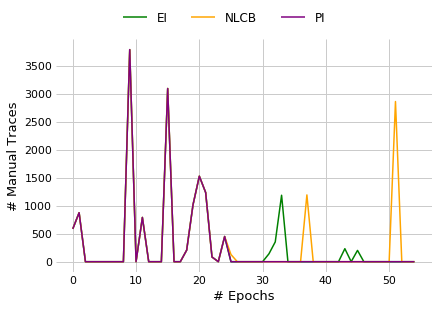

In [56]:
# Plot function output across epochs
y1 = [ele[0]*nppl for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0]*nppl for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0]*nppl for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(KEY, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [57]:
## df aggregate 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei[KEY] = ei_bayesopt_loop.model.model.Y * nppl

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb[KEY] = nlcb_bayesopt_loop.model.model.Y * nppl

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi[KEY] = pi_bayesopt_loop.model.model.Y * nppl

# Store the result
df_ei.to_csv("../results/ei-bo-unconstrained-manual.csv")
df_nlcb.to_csv("../results/nlcb-bo-unconstrained-manual.csv")
df_pi.to_csv("../results/pi-bo-unconstrained-manual.csv")

In [58]:
## Sort policies result
df_ei = pd.read_csv("../results/ei-bo-unconstrained-manual.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-unconstrained-manual.csv")
df_pi = pd.read_csv("../results/pi-bo-unconstrained-manual.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# Manual Traces
27,0.640117,0.218414,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000
53,0.862198,0.126413,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000
28,0.681587,0.335601,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000
29,0.733412,0.120990,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000
30,0.782235,0.344576,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000
34,0.160608,0.705369,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000
35,0.596076,0.160332,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000
36,0.663308,0.292936,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000
37,0.250982,0.007857,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000
38,0.023721,0.935373,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000


### # of PersonDays Quarantined

In [59]:
KEY = "# PersonDays Quarantined"

In [60]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [61]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [62]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

Optimization restart 1/1, f = 119.33302614581649



Optimization restart 1/1, f = 123.60035156962711



Optimization restart 1/1, f = 127.83242045807448



Optimization restart 1/1, f = 132.03435959636442



Optimization restart 1/1, f = 136.20837815701626



Optimization restart 1/1, f = 140.35694494799094



Optimization restart 1/1, f = 144.48176271785903



Optimization restart 1/1, f = 148.58421570834872



Optimization restart 1/1, f = 152.66552652405474



Optimization restart 1/1, f = 156.72649710017185



Optimization restart 1/1, f = 160.76824075508773



Optimization restart 1/1, f = 164.79122901776344



Optimization restart 1/1, f = 168.79633481019883



Optimization restart 1/1, f = 172.78406461119488



Optimization restart 1/1, f = 176.75492620697827



Optimization restart 1/1, f = 180.70935932063767



Optimization restart 1/1, f = 184.64773470907716



Optimization restart 1/1, f = 188.57034623012936



Optimization restart 1/1, f = 192.4773919671843



Optimization restart 1/1, f = 196.36892518975043



Optimization restart 1/1, f = 200.2447293495983



Optimization restart 1/1, f = 204.10706219925842



Optimization restart 1/1, f = 8.865781373894762



Optimization restart 1/1, f = -29.793871207720798



Optimization restart 1/1, f = -25.452191120435884



Optimization restart 1/1, f = -21.10917607286316



Optimization restart 1/1, f = -16.718370325813243



Optimization restart 1/1, f = -12.448993846470657



Optimization restart 1/1, f = -8.105668811080516



Optimization restart 1/1, f = -3.7814629759797427



Optimization restart 1/1, f = 2.016612564387355
Optimization restart 1/1, f = 119.3330261458165



Optimization restart 1/1, f = 123.60035156962711



Optimization restart 1/1, f = 127.83242045807448



Optimization restart 1/1, f = 132.03389809482965



Optimization restart 1/1, f = 136.2077783937388



Optimization restart 1/1, f = 140.35621617394852



Optimization restart 1/1, f = 144.48090940764268



Optimization restart 1/1, f = 148.58324178862665



Optimization restart 1/1, f = 152.6644351632912



Optimization restart 1/1, f = 156.72528602933434



Optimization restart 1/1, f = 160.7669143293921



Optimization restart 1/1, f = 164.78977850383876



Optimization restart 1/1, f = 168.79475932678116



Optimization restart 1/1, f = 172.78235857181213



Optimization restart 1/1, f = 176.75502600081737



Optimization restart 1/1, f = 180.7093593997703



Optimization restart 1/1, f = 184.64959159640895



Optimization restart 1/1, f = 188.57237538719988



Optimization restart 1/1, f = 192.4796178426403



Optimization restart 1/1, f = 196.3713883710796



Optimization restart 1/1, f = 200.24750389041083



Optimization restart 1/1, f = 204.10706156387351



Optimization restart 1/1, f = -31.254278000788155



Optimization restart 1/1, f = -26.852411333487595



Optimization restart 1/1, f = -22.442851226998627



Optimization restart 1/1, f = -17.76231187473274



Optimization restart 1/1, f = -13.385545775394586



Optimization restart 1/1, f = -8.44477431821569



Optimization restart 1/1, f = -2.811039136891008



Optimization restart 1/1, f = 1.57069362737667



Optimization restart 1/1, f = 9.3342965585183
Optimization restart 1/1, f = 119.3330261458165



Optimization restart 1/1, f = 123.59986397709653



Optimization restart 1/1, f = 127.83177977171766



Optimization restart 1/1, f = 132.03311699432294



Optimization restart 1/1, f = 136.2068682758353



Optimization restart 1/1, f = 140.35518354417633



Optimization restart 1/1, f = 144.47975900204835



Optimization restart 1/1, f = 148.58197576408142



Optimization restart 1/1, f = 152.66305521400264



Optimization restart 1/1, f = 156.7237905782437



Optimization restart 1/1, f = 160.7652998028527



Optimization restart 1/1, f = 164.78804375386255



Optimization restart 1/1, f = 168.79289854502278



Optimization restart 1/1, f = 172.78036503034795



Optimization restart 1/1, f = 176.75094618323092



Optimization restart 1/1, f = 180.70507681716833



Optimization restart 1/1, f = 184.64311850164026



Optimization restart 1/1, f = 188.5653534621171



Optimization restart 1/1, f = 192.47195909066974



Optimization restart 1/1, f = 196.36294983143335



Optimization restart 1/1, f = 200.23800745953017



Optimization restart 1/1, f = 204.0954602487912



Optimization restart 1/1, f = -44.441174488582334



Optimization restart 1/1, f = -40.02207595172969



Optimization restart 1/1, f = -35.61450240719847



Optimization restart 1/1, f = -31.211973146241235



Optimization restart 1/1, f = -26.842606130855224



Optimization restart 1/1, f = -22.493131849952462



Optimization restart 1/1, f = -16.788609368463682



Optimization restart 1/1, f = -12.425734056595534



Optimization restart 1/1, f = -7.721151541085661


In [63]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum # PersonDays Quarantined: 0.0
Strategy:


{'go_to_school_prob': 0.26400565055253955,
 'wfh_prob': 0.09454675524502343,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 15.0,
 'quarantine_length': 0.0}

,Simulation results:
Base R,3.9
Effective R,3.0
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


In [64]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
Minimum # PersonDays Quarantined: 0.0
Strategy:


{'go_to_school_prob': 0.26400565055253955,
 'wfh_prob': 0.09454675524502343,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 15.0,
 'quarantine_length': 0.0}

,Simulation results:
Base R,3.9
Effective R,3.0
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


In [65]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"Minimum {KEY}: {results.minimum_value*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
Minimum # PersonDays Quarantined: 0.0
Strategy:


{'go_to_school_prob': 0.26400565055253955,
 'wfh_prob': 0.09454675524502343,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 15.0,
 'quarantine_length': 0.0}

,Simulation results:
Base R,3.9
Effective R,3.0
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


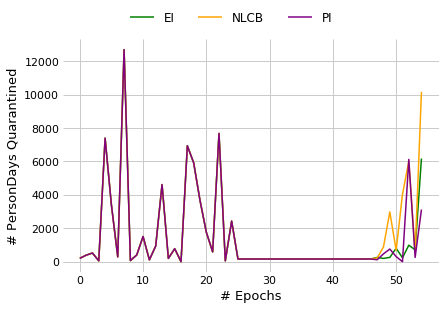

In [66]:
# Plot function output across epochs
y1 = [ele[0]*nppl for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0]*nppl for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0]*nppl for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(KEY, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [ ]:
##### df aggregate 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei[KEY] = ei_bayesopt_loop.model.model.Y * nppl

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb[KEY] = nlcb_bayesopt_loop.model.model.Y * nppl

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi[KEY] = pi_bayesopt_loop.model.model.Y * nppl

# Store the result
df_ei.to_csv("../results/ei-bo-unconstrained-days.csv")
df_nlcb.to_csv("../results/nlcb-bo-unconstrained-days.csv")
df_pi.to_csv("../results/pi-bo-unconstrained-days.csv")

In [68]:
## Sort policies result
df_ei = pd.read_csv("../results/ei-bo-unconstrained-days.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-unconstrained-days.csv")
df_pi = pd.read_csv("../results/pi-bo-unconstrained-days.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# PersonDays Quarantined
16,0.264006,9.454676e-02,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,15.0,0.0,0.000
23,0.277842,3.378509e-01,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,3.0,51.048
3,0.925700,9.918134e-01,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,20.0,2.0,53.112
8,0.247015,4.772343e-01,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,20.0,2.0,68.496
11,0.143703,4.005621e-01,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,110.088
27,1.000000,1.000000e+00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,0.0,160.272
26,1.000000,1.000000e+00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,20.0,0.0,160.272
25,1.000000,1.000000e+00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,0.0,160.272
30,1.000000,1.000000e+00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,20.0,0.0,160.272
31,1.000000,1.000000e+00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,20.0,0.0,160.272


## Random Search

In this section, we find the optimal policy/ strategy using random search. We consider variables that we can optimise including:

* go_to_school_prob
* wfh_prob
* isolate_individual_on_symptoms
* isolate_individual_on_positive
* isolate_household_on_symptoms
* isolate_household_on_positive
* isolate_contacts_on_symptoms
* isolate_contacts_on_positive
* test_contacts_on_positive
* do_symptom_testing
* do_manual_tracing
* do_app_tracing
* max_contacts
* quarantine_length

See **Utilities.ipynb** for description of each variable.

### Effective R

In [7]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         "Effective R")
    return y

In [8]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 55
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

In [10]:
## Probability of Improvement Policy
results = np.array(y)
print(f"Minimum Effective R: {np.min(y)}")
print("Strategy:")
res = {variables_to_optimise[i]: x[np.argmin(y)][i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

Minimum Effective R: 0.8280578814967346
Strategy:


{'go_to_school_prob': 0.9542775228824841,
 'wfh_prob': 0.9802380297631731,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 1.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 1.0,
 'do_app_tracing': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 12.0}

,Simulation results:
Base R,3.9
Effective R,0.8
# Manual Traces (k per day),108.3
# App Traces (k per day),15.8
# Tests Needed (k per day),173.7


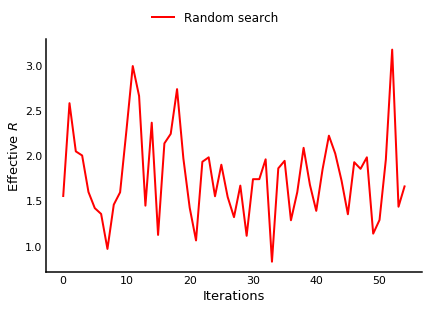

In [13]:
# Plot function output across epochs
y = results.flatten()
x_plot = range(len(y))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y, "red", label="Random search", linewidth=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.25, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("Iterations", fontsize=13)
ax.set_ylabel("Effective $R$", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")
ax.grid(False)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

In [87]:
## Parallel coordinate plot 
df_rs = pd.DataFrame(x, columns=variables_to_optimise)
df_rs['Effective R'] = y.flatten()

In [89]:
df_rs.sort_values("Effective R").head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,Effective R
16,0.440162,0.830128,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,7.0,0.767063
21,0.145695,0.841531,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,3.0,0.771205
23,0.294571,0.644183,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,1.043699
42,0.003710,0.990616,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0,0.0,1.080247
40,0.546557,0.798479,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,13.0,1.124607
38,0.012463,0.395599,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,1.173793
37,0.212404,0.929534,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,3.0,1.179409
27,0.497528,0.978621,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,16.0,6.0,1.219336
17,0.653473,0.828896,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8.0,1.0,1.221403
26,0.356673,0.632205,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,10.0,1.293193


### # Tests Needed

In [90]:
KEY = "# Tests Needed"
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [91]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 55
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

In [92]:
## Probability of Improvement Policy
results = np.array(y)
print(f"Minimum {KEY}: {np.min(y)*nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: x[np.argmin(y)][i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

Minimum # Tests Needed: 0.0
Strategy:


{'go_to_school_prob': 0.7148158875212215,
 'wfh_prob': 0.6333523716349921,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 8.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,2.0
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


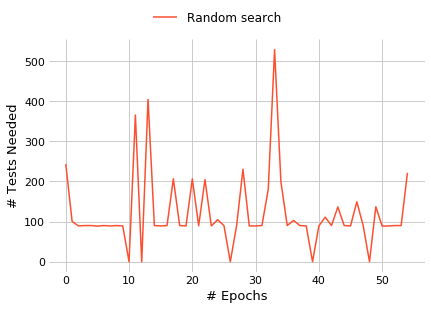

In [93]:
# Plot function output across epochs
y = results.flatten() * nppl
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y, "C7", label="Random search", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.25, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(f"{KEY}", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [94]:
## Parallel coordinate plot 
df_rs = pd.DataFrame(x, columns=variables_to_optimise)
df_rs[KEY] = y.flatten() * nppl

In [95]:
df_rs.sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# Tests Needed
48,0.536488,0.008583,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,4.0,0.00
10,0.714816,0.633352,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,14.0,0.00
39,0.429150,0.745605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,1.0,0.00
12,0.732079,0.950373,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,11.0,0.00
26,0.605091,0.485146,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,6.0,0.00
5,0.778201,0.834384,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,10647.36
50,0.766580,0.297965,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,4.0,10647.36
30,0.840934,0.195685,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,10702.08
15,0.631921,0.899645,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,3.0,10702.08
23,0.971099,0.814831,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,13.0,4.0,10702.08


### # Manual Traces

In [96]:
KEY = "# Manual Traces"
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [97]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 55
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

In [98]:
## Probability of Improvement Policy
results = np.array(y)
print(f"Minimum {KEY}: {np.min(y) * nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: x[np.argmin(y)][i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

Minimum # Manual Traces: 0.0
Strategy:


{'go_to_school_prob': 0.9294583267978469,
 'wfh_prob': 0.8711435413695319,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 1.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 11.0,
 'quarantine_length': 6.0}

,Simulation results:
Base R,3.9
Effective R,1.6
# Manual Traces (k per day),0.0
# App Traces (k per day),462.9
# Tests Needed (k per day),88.7


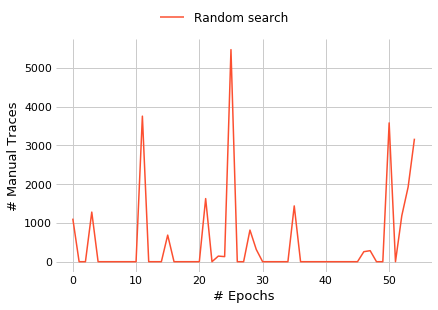

In [99]:
# Plot function output across epochs
y = results.flatten() * nppl
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y, "C7", label="Random search", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.25, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(f"{KEY}", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [100]:
## Parallel coordinate plot 
df_rs = pd.DataFrame(x, columns=variables_to_optimise)
df_rs[KEY] = y.flatten()*nppl

In [101]:
df_rs.sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# Manual Traces
27,0.777564,0.684483,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,17.0,14.0,0.00
48,0.439450,0.746671,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,15.0,14.0,0.00
43,0.240736,0.241802,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,18.0,1.0,0.00
26,0.561239,0.854644,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,0.00
30,0.750176,0.538412,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,9.0,0.00
31,0.957660,0.775235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,13.0,5.0,0.00
32,0.294353,0.153416,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,8.0,0.00
33,0.474234,0.002322,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,16.0,1.0,0.00
20,0.019947,0.174656,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,20.0,12.0,0.00
34,0.387129,0.759925,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,13.0,11.0,0.00


### # PersonDays Quarantined

In [102]:
KEY = "# PersonDays Quarantined"
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         KEY)
    return y

In [103]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 55
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

In [104]:
## Probability of Improvement Policy
results = np.array(y)
print(f"Minimum {KEY}: {np.min(y) * nppl}")
print("Strategy:")
res = {variables_to_optimise[i]: x[np.argmin(y)][i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

Minimum # PersonDays Quarantined: 73.39200000000001
Strategy:


{'go_to_school_prob': 0.38000338113860144,
 'wfh_prob': 0.45163575989332017,
 'isolate_individual_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 1.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 4.0}

,Simulation results:
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),90.1


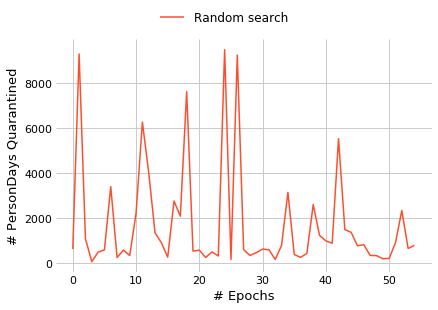

In [105]:
# Plot function output across epochs
y = results.flatten()*nppl
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y, "C7", label="Random search", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.25, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel(f"{KEY}", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [106]:
## Parallel coordinate plot 
df_rs = pd.DataFrame(x, columns=variables_to_optimise)
df_rs[KEY] = y.flatten()*nppl

In [107]:
df_rs.sort_values(KEY).head(50)

,go_to_school_prob,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,# PersonDays Quarantined
3,0.380003,0.451636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,8807.04
25,0.519940,0.919158,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,1.0,20494.08
32,0.206252,0.375282,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,7.0,20956.32
49,0.273562,0.761402,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,12.0,24503.04
50,0.979894,0.273364,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,26167.68
7,0.383250,0.774663,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0,10.0,30706.56
21,0.991952,0.951051,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,1.0,31259.52
36,0.806768,0.035116,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,31871.52
15,0.848842,0.661536,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,12.0,32976.00
23,0.710216,0.393643,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,17.0,7.0,39090.24
